In [13]:
### Analysis Traveling Waves

import numpy as np
import scipy as sp
import mne
import matplotlib
import matplotlib.pyplot as plt
from mne.datasets import spm_face
from scipy import fft, ifft, signal
from mne.preprocessing import ICA
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs, compute_source_psd_epochs, source_band_induced_power, source_induced_power, compute_source_psd
%matplotlib inline

# Read Pre-processed data
raw_path = mne.read_epochs('/home/robertofelipe_sg/Documents/Preprocessed/Bursts/B_Gas_preprocessed_epo.fif')
raw_path.set_eeg_reference('average', projection=True)
raw_path.apply_proj()
sub = raw_path['verum_cor']
 
# Source Reconstruction
data_path = spm_face.data_path()
src = data_path + '/subjects/spm/bem/spm-oct-6-src.fif'
bem = data_path + '/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif'
cov = mne.compute_covariance(sub, tmin=-.300, tmax=-.100, method='empirical')
fwd = mne.make_forward_solution(sub.info, 'fsaverage', src, bem, eeg=True)
inv = make_inverse_operator(sub.info, fwd, cov, loose=0.2, depth=0.8)
names = ['rh.V1','rh.MT'] # Read labels of interest
labels_parc = [mne.read_label(data_path + '/subjects/spm/label/%s.label' % name) for name in names]

# Compute inverse solution on signal
stc = apply_inverse_epochs(sub, inv, lambda2=1/9, pick_ori='normal', method='MNE')
ch_index = mne.extract_label_time_course(stc, labels_parc, inv['src'], mode='pca_flip', 
                                                     allow_empty=True,return_generator=False) 
data = np.array(ch_index) # trials x chans x timep
# print(data.shape, data.dtype)
# data_avg = np.mean(data, axis=0) # averaging over epochs

# Baseline definition
baseline_window = np.array([-0.3, -0.1]);

# Baseline time into indices
baseidx1 = int(((baseline_window[0]+1.5)*data.shape[2])/3)
baseidx2 = int(((baseline_window[1]+1.5)*data.shape[2])/3)

# Frequency Parameters
min_freq = 7
max_freq = 77
num_freq = 70
frex = np.linspace(min_freq, max_freq, num_freq)

# Parameters Morlet Wavelet
cyc_rng = np.array([3, 10])
srate = 250
timew = np.arange(-2,2,1/srate)
s = (np.logspace(np.log10(cyc_rng[0]), np.log10(cyc_rng[1]), num_freq)) / (2*np.pi*frex)
half_w = (len(timew)/2) +1
half_w = int(half_w)

# Initialize output Time-Frequency
tifr = np.empty((len(frex), data.shape[2]))
itpc = np.empty((len(labels_parc), len(frex), data.shape[2]))
ispc = np.empty((len(frex), data.shape[2]))
phase_data = np.empty((len(labels_parc),len(frex), data.shape[0], data.shape[2]))
tifrx = np.empty((len(labels_parc), len(frex), data.shape[2]), dtype=int)
mean_tf = np.empty((len(frex), data.shape[2]))
nData = data.shape[0] * data.shape[2] #* len(ch_index)
nConv = len(timew) + nData - 1
areg = np.empty((data.shape[0], len(labels_parc), data.shape[2]))

# Looping over channels
for c, _ in enumerate(labels_parc):
    
    # FFT on all trials concatenated
    alldata = np.reshape(data[:,c,:], (1,nData))
    areg[:,c,:] = data[:,c,:]
    datax = fft.fft(alldata, nConv)
    
    # Looping over Frequencies
    for idx, f in enumerate(frex):

        # Create best wavelet according to frequency of analysis (best resolution)
        wavelet = (np.exp(2j*np.pi*f*timew)) * (np.exp((-timew**2)/(2*s[idx]**2)))
        wavex = fft.fft(wavelet, nConv)
        wavex = wavex / max(wavex)

        # Applying convolution in the Freq.Domain
        convo = fft.ifft(datax*wavex)
        convo = convo[0, half_w-1 : len(convo)-half_w+1]

        # Reshape into trials x time
        convo = np.reshape(convo, (data.shape[0], data.shape[2]))

        # Average over all trials
        tifr[idx,:] = np.mean(np.abs(convo)**2, axis=0)
        
        # Compute ITPC -> Mean over trials
        itpc[c,idx,:] = abs(np.mean(np.exp(1j*(np.angle(convo))),0))
               
        # Calculate angle for every channel
        phase_data[c,idx,:,:] = np.angle(convo)
            
    # Decibel Normalization    
    tifrx[c,:,:] = (10*np.log10([tifr[:,i] / (np.mean(tifr[:,baseidx1:baseidx2],1)) for i in range(data.shape[2])])).T

    # Average over channels
    mean_tf[:,:] = np.mean(tifrx, axis=0)
            
# Phase Difference & PLV
ph_diff = phase_data[1,:,:,:] - phase_data[0,:,:,:]                           # frex x trials x time-points
ispc_freq = abs((np.mean(np.exp(1j*ph_diff),1)))                              # frex x time-points

Reading /home/robertofelipe_sg/Documents/Preprocessed/Bursts/B_Gas_preprocessed_epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2496.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
290 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Computing rank from data with rank=None
    Using tolerance 2.2e-11 (2.2e-16 eps * 63 dim * 1.6e+03  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 63 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 63 -> 62
Estimati

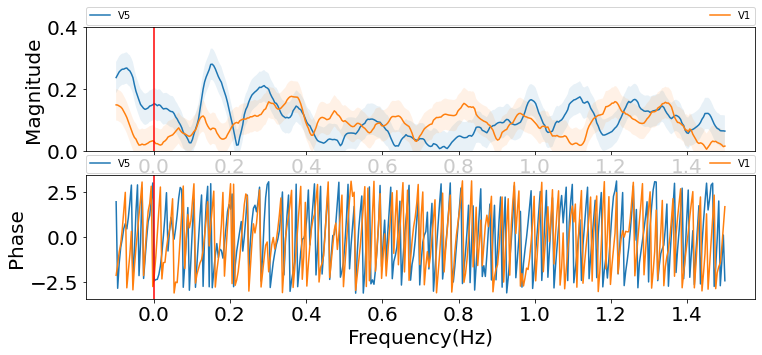

In [14]:
### Averaged Evoked Potentials --> Magnitude & Phase

# ph_diff         # frex x trials x time-points
# ispc_freq       # frex x time-points
# ispc_time       # Magntiude over time-points Alpha
# ispc_alpha      # Angle over time-points Alpha
# ispc_tri        # Magnitude over trials during stim onset
# ispc_ang_tr     # Angle over trials during stim onset

# Phase Difference
ph_diff = phase_data[1,:,:,:] - phase_data[0,:,:,:]                           # Ch x frex x trials x time-points
V5_time = abs(np.mean(np.mean(np.exp(1j*phase_data[1,3:6,:,:]),1),0))           # Magnitude over time-points Alpha
V1_time = abs(np.mean(np.mean(np.exp(1j*phase_data[0,3:6,:,:]),1),0))           # Magnitude over time-points Alpha
V5_ang = np.angle(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,:]),1),0))       # Angle over time-points Alpha
V1_ang = np.angle(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,:]),1),0))       # Angle over time-points Alpha

min_time = -1.5
max_time = 2.5
num_time = 1000
timex = np.linspace(min_time, max_time, num_time)

fig1 = plt.figure(figsize=(12,5))

ax1 = fig1.add_subplot(2,1,1)
stdev1 = np.std(V5_time)
ax1.plot(timex[350:750], V5_time[350:750], label='V5')
ax1.fill_between(timex[350:750], V5_time[350:750]+stdev1, V5_time[350:750]-stdev1,alpha=.1)
stdev2 = np.std(V1_time)
ax1.plot(timex[350:750], V1_time[350:750], label='V1')
ax1.fill_between(timex[350:750], V1_time[350:750]+stdev1, V1_time[350:750]-stdev1,alpha=.1)
ax1.set_ylim(0,0.4)
ax1.tick_params(labelsize=20)
ax1.set_ylabel('Magnitude', fontsize=20)
# ax1.set_xlabel('Time(s)', fontsize=20)
ax1.axvline(0, color='r') # Show Stim Onset
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax2 = fig1.add_subplot(2,1,2)
ax2.plot(timex[350:750], V5_ang[350:750], label='V5')
ax2.plot(timex[350:750], V1_ang[350:750], label='V1')
# ax2.set_ylim(0,0.2)
ax2.tick_params(labelsize=20)
ax2.set_ylabel('Phase', fontsize=20)
ax2.set_xlabel('Frequency(Hz)', fontsize=20)
ax2.axvline(0, color='r') # Show Stim Onset
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)


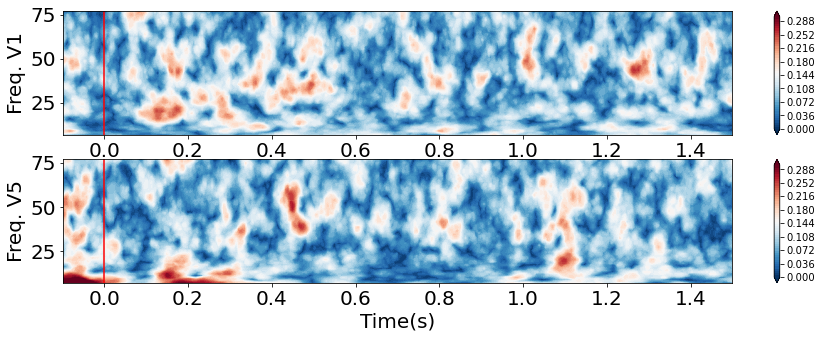

In [15]:
### Inter Trial Phase consistency
from matplotlib.ticker import MaxNLocator

V5_frex = abs((np.mean(np.exp(1j*phase_data[1,:,:,:]),1)))                    # frex x time-points
V1_frex = abs((np.mean(np.exp(1j*phase_data[0,:,:,:]),1)))                    # frex x time-points

fig2 = plt.figure(figsize=(15,5))

vmax=  0.3
vmin=  0.0
levels = MaxNLocator(nbins=50).tick_values(vmin, vmax)

ax3 = fig2.add_subplot(2,1,1)
CS3 = ax3.contourf(timex[350:750], frex, V1_frex[:,350:750], cmap='RdBu_r', levels=levels, extend='both')
fig1.colorbar(CS3, ax=ax3)
ax3.tick_params(labelsize=20)
ax3.set_ylabel('Freq. V1', fontsize=20)
ax3.set_xlabel('Time(s)', fontsize=20)
ax3.axvline(0, color='r') # Show Stim Onset

ax4 = fig2.add_subplot(2,1,2)
CS4 = ax4.contourf(timex[350:750], frex, V5_frex[:,350:750], cmap='RdBu_r', levels=levels, extend='both')
fig1.colorbar(CS4, ax=ax4)
ax4.tick_params(labelsize=20)
ax4.set_ylabel('Freq. V5', fontsize=20)
ax4.set_xlabel('Time(s)', fontsize=20)
ax4.axvline(0, color='r') # Show Stim Onset


(70, 57, 1000)


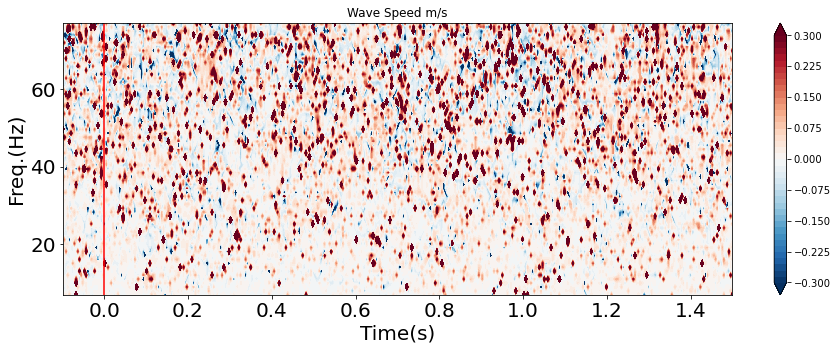

In [12]:
### Speed Traveling Wave

from matplotlib.ticker import MaxNLocator

tw_speed = np.empty((frex.shape[0],data.shape[0],data.shape[2])) # frex x trials x timep
print(tw_speed.shape)
for e in range(data.shape[0]):
    for t in range(data.shape[2]):
        tw_speed[:,e,t] = 0.01 / (250*(np.rad2deg(ph_diff[:,e,t])) / (360*2*np.pi*frex))  #1cm distance V1-V5
        
# print(np.mean(tw_speed[:,:,350:550],axis=1))
        
fig3 = plt.figure(figsize=(15,5))
vmax=  0.3
vmin= -0.3
levels = MaxNLocator(nbins=50).tick_values(vmin, vmax)
CS = plt.contourf(timex[350:750], frex, np.mean(tw_speed[:,:,350:750], axis=1), cmap='RdBu_r', levels=levels, extend='both')
fig3.colorbar(CS)
plt.title('Wave Speed m/s')
plt.tick_params(labelsize=20)
plt.ylabel('Freq.(Hz)', fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.axvline(0, color='r') # Show Stim Onset

(70, 1000)


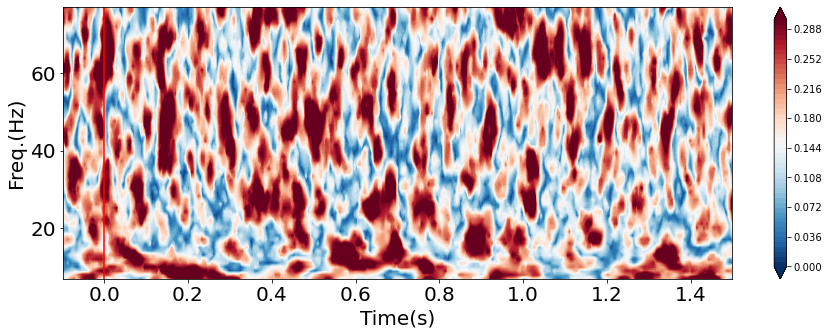

In [6]:
### Phase Locking Value

PLV = abs(np.mean(np.exp(1j*ph_diff),1))                     # Magntiude over time-points Alpha
print(PLV.shape)

fig5 = plt.figure(figsize=(15,5))

vmax=  0.3
vmin=  0.0
levels = MaxNLocator(nbins=50).tick_values(vmin, vmax)

CS3 = plt.contourf(timex[350:750], frex, PLV[:,350:750], cmap='RdBu_r', levels=levels, extend='both')
fig5.colorbar(CS3)
plt.tick_params(labelsize=20)
plt.ylabel('Freq.(Hz)', fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.axvline(0, color='r') # Show Stim Onset

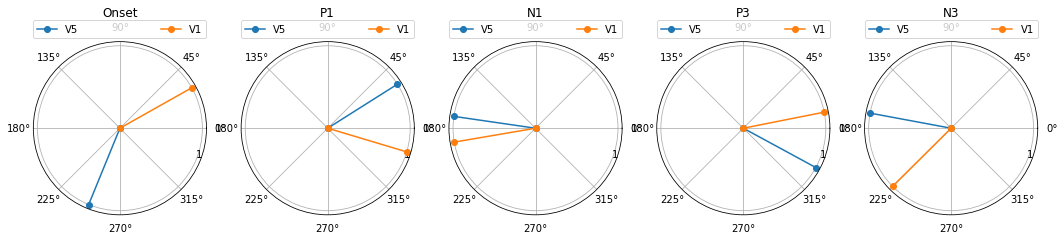

In [19]:
### Averaged Polar representation

V5_mag_onset = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,372:378]),2),0),0))      # Magnitude over trials during stim onset
V5_ang_onset = np.angle(np.mean(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,372:378]),2),0),0)) # Angle over trials during stim onset
V1_mag_onset = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,372:378]),2),0),0))      # Magnitude over trials during stim onset
V1_ang_onset = np.angle(np.mean(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,372:378]),2),0),0)) # Angle over trials during stim onset

V5_mag_P1 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,387:412]),2),0),0))      # Magnitude over trials during stim onset
V5_ang_P1 = np.angle(np.max(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,387:412]),2),0),0)) # Angle over trials during stim onset
V1_mag_P1 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,387:412]),2),0),0))      # Magnitude over trials during stim onset
V1_ang_P1 = np.angle(np.max(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,387:412]),2),0),0)) # Angle over trials during stim onset

V5_mag_N1 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,412:437]),2),0),0))      # Magnitude over trials during stim onset
V5_ang_N1 = np.angle(np.min(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,412:437]),2),0),0)) # Angle over trials during stim onset
V1_mag_N1 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,412:437]),2),0),0))      # Magnitude over trials during stim onset
V1_ang_N1 = np.angle(np.min(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,412:437]),2),0),0)) # Angle over trials during stim onset

V5_mag_P3 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,437:463]),2),0),0))      # Magnitude over trials during stim onset
V5_ang_P3 = np.angle(np.max(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,437:463]),2),0),0)) # Angle over trials during stim onset
V1_mag_P3 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,437:463]),2),0),0))      # Magnitude over trials during stim onset
V1_ang_P3 = np.angle(np.max(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,437:463]),2),0),0)) # Angle over trials during stim onset

V5_mag_N3 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,464:490]),2),0),0))      # Magnitude over trials during stim onset
V5_ang_N3 = np.angle(np.min(np.mean(np.mean(np.exp(1j*phase_data[1,:,:,464:490]),2),0),0)) # Angle over trials during stim onset
V1_mag_N3 = abs(np.mean(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,464:490]),2),0),0))      # Magnitude over trials during stim onset
V1_ang_N3 = np.angle(np.min(np.mean(np.mean(np.exp(1j*phase_data[0,:,:,464:490]),2),0),0)) # Angle over trials during stim onset

fig4 = plt.figure(figsize=(18,4))

ax5 = fig4.add_subplot(1,5,1, projection='polar')
ax5.plot((0,V5_ang_onset), (0,1), marker='o', label='V5')
ax5.plot((0,V1_ang_onset), (0,1), marker='o', label='V1')
ax5.set_rticks([1])  # Less radial ticks
ax5.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax5.tick_params(labelsize=20)
ax5.grid(True)
ax5.set_title('Onset')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax6 = fig4.add_subplot(1,5,2, projection='polar')
ax6.plot((0,V5_ang_P1), (0,1), marker='o', label='V5')
ax6.plot((0,V1_ang_P1), (0,1), marker='o', label='V1')
ax6.set_rticks([1])  # Less radial ticks
ax6.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax6.grid(True)
ax6.set_title('P1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax7 = fig4.add_subplot(1,5,3, projection='polar')
ax7.plot((0,V5_ang_N1), (0,1), marker='o', label='V5')
ax7.plot((0,V1_ang_N1), (0,1), marker='o', label='V1')
ax7.set_rticks([1])  # Less radial ticks
ax7.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax7.grid(True)
ax7.set_title('N1')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax8 = fig4.add_subplot(1,5,4, projection='polar')
ax8.plot((0,V5_ang_P3), (0,1), marker='o', label='V5')
ax8.plot((0,V1_ang_P3), (0,1), marker='o', label='V1')
ax8.set_rticks([1])  # Less radial ticks
ax8.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax8.grid(True)
ax8.set_title('P3')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax9 = fig4.add_subplot(1,5,5, projection='polar')
ax9.plot((0,V5_ang_N3), (0,1), marker='o', label='V5')
ax9.plot((0,V1_ang_N3), (0,1), marker='o', label='V1')
ax9.set_rticks([1])  # Less radial ticks
ax9.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax9.grid(True)
ax9.set_title('N3')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)


In [ ]:
P1_V1 = [np.max(abs(np.mean(np.exp(1j*phase_data[0,:,i,387:412]),0))) for i in range(data.shape[0])]
P1_V5 = [np.max(abs(np.mean(np.exp(1j*phase_data[1,:,i,387:412]),0))) for i in range(data.shape[0])]
N1_V1 = [np.min(abs(np.mean(np.exp(1j*phase_data[0,:,i,413:438]),0))) for i in range(data.shape[0])]
N1_V5 = [np.min(abs(np.mean(np.exp(1j*phase_data[1,:,i,413:438]),0))) for i in range(data.shape[0])]
print(np.array(N1_V1).shape)

In [89]:
print(timex[466:490])

[0.36648865 0.37049399 0.37449933 0.37850467 0.38251001 0.38651535
 0.39052069 0.39452603 0.39853138 0.40253672 0.40654206 0.4105474
 0.41455274 0.41855808 0.42256342 0.42656876 0.4305741  0.43457944
 0.43858478 0.44259012 0.44659546 0.4506008  0.45460614 0.45861148]


In [38]:
a=np.load('Wave___1.npy' )
print(a.shape)
b = abs(np.mean(a[1,3:6,:]),0)

(2, 44, 1000)


TypeError: abs() takes exactly one argument (2 given)

In [42]:
ph_diff

array([[[ 3.23751472,  3.4193398 ,  3.59318617, ..., -0.90636833,
         -0.96277391, -1.01439498],
        [-1.06077587,  5.1814113 ,  5.14569613, ..., -4.10079147,
         -4.09873626, -4.09603294],
        [-4.09255359, -4.08816696, -4.08273778, ..., -4.82207599,
         -4.78726597,  1.52772086],
        ...,
        [ 2.68969495,  2.66289271,  2.63210617, ...,  1.48451508,
          1.44848171,  1.39449596],
        [ 1.32010456,  1.22423522,  1.10874097, ..., -3.10634016,
         -3.07027646, -3.03923896],
        [-3.01475573,  3.28502491,  3.29270443, ...,  3.91720122,
          3.87347285,  3.83059443]],

       [[ 1.19391172,  0.81710005, -0.15013611, ..., -0.98302088,
         -1.00311255, -1.02310117],
        [-1.04268594,  5.22153587,  5.2033478 , ..., -3.86872209,
         -3.87599331, -3.88267124],
        [-3.88863355, -3.89377   , -3.89798126, ..., -4.59228469,
         -4.56577144, -4.54066126],
        ...,
        [ 2.36481654,  2.26978996,  2.16099128, ...,  